In [1]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [22]:
import torchsde
import time
import types
from scvi.module.base import LossOutput
import matplotlib.cm as cm

In [37]:
# define updated functions for deterministic version

def random_walk_deterministic(
    self, z, initial_states, n_jumps, n_steps
):
    assert n_steps >= n_jumps, "step before you can jump"
    initial_states = initial_states.reshape(-1, 1)
    paths = initial_states.repeat(1, n_jumps)
    for i in range(n_jumps - 1):
        paths[:, i + 1] = self.T[paths[:, i]].argmax(1).flatten()
    if self.use_terminal_states:
        paths = self.apply_terminal_states(paths)
    walks = z[paths]
    if self.use_spline:
        walks = self.apply_spline(walks, n_jumps, n_steps)
    return walks.detach()

def loss_edited(
    self,
    tensors,
    inference_outputs,
    generative_outputs,
):
    z_s = generative_outputs["z_s"]
    z_m = generative_outputs["z_m"].detach()

    rcn_loss = (z_m - z_s).pow(2)
    loss = torch.mean(rcn_loss)

    return LossOutput(
        loss=loss, reconstruction_loss=rcn_loss, kl_local={"kld": torch.tensor(0.0, device=self.device)}
    )


# NMP

In [4]:
# load data

nmp = sc.read_h5ad('../data/nmp_data_1606.h5ad')
nmp

# load VAE model

state_path = '../models/nmp_vf_1606_model.pt'

vt.md.Velvet.setup_anndata(nmp, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    nmp,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

trained_state = torch.load(state_path)['model_state_dict']

model.module.load_state_dict(trained_state)
model.module = model.module.to('cuda')

X = torch.tensor(model.adata.obsm['X_z'], device=model.device)

INFO     Generating sequential column names                                                  


In [10]:
# define stochastic model

mp1 = vt.sb.MarkovProcess(
    model,
    n_neighbors=10,
    use_space='latent_space',
    use_spline=True,
    use_similarity=False
)

sde1 = vt.sb.SDE(
    model.module.n_latent,
    prior_vectorfield=model.module.vf,
    noise_scalar=0.2,
    device=model.device
)

model.adata.obs['index'] = np.arange(model.adata.shape[0])

vt.sm.VelvetSDE.setup_anndata(
    model, 
    x_layer='total', 
    index_key='index'
)

sde_model = vt.sm.VelvetSDE(
    model,
    sde1,
    mp1,
)

sde_model.module = sde_model.module.to('cuda')

# defome deterministic model

mp2 = vt.sb.MarkovProcess(
    model,
    n_neighbors=10,
    use_space='latent_space',
    use_spline=True,
    use_similarity=False
)

mp2.random_walk = types.MethodType(random_walk_deterministic, mp2)

sde2 = vt.sb.SDE(
    model.module.n_latent,
    prior_vectorfield=model.module.vf,
    noise_scalar=0.0,
    device=model.device
)

model.adata.obs['index'] = np.arange(model.adata.shape[0])

vt.sm.VelvetSDE.setup_anndata(
    model, 
    x_layer='total', 
    index_key='index'
)

det_model = vt.sm.VelvetSDE(
    model,
    sde2,
    mp2,
)

det_model.module = det_model.module.to('cuda')

det_model.module.loss = types.MethodType(loss_edited, det_model.module)

KNN indices for Velvet stored in .obsm['knn_index'].
KNN indices for Velvet stored in .obsm['knn_index'].


In [11]:
# train models

sde_model.train(
    max_epochs = 250,
    n_trajectories = 200,
    n_simulations = 50,
    n_steps = 30,
    n_markov_steps=15,
    t_max=25,
    dt = 1.0,
    lr = 0.001,
)

det_model.train(
    max_epochs = 250,
    n_trajectories = 200*50,
    n_simulations = 1,
    n_steps = 30,
    n_markov_steps=15,
    t_max=25,
    dt = 1.0,
    lr = 0.001,
)

Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 250/250: 100%|██████████| 250/250 [01:46<00:00,  2.36it/s, loss=121, v_num=1] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [01:46<00:00,  2.35it/s, loss=121, v_num=1]


Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 250/250: 100%|██████████| 250/250 [01:19<00:00,  3.16it/s, loss=0.361, v_num=1]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [01:19<00:00,  3.16it/s, loss=0.361, v_num=1]


In [15]:
n_trajectories = 1000
n_steps = 200
t_max = 60
dt = 1.0
beginning_pct = 20
components=[0,1]
one_color=False
alpha=0.2

z = torch.tensor(sde_model.adata.obsm['X_z'])
z_data = sde_model.adata[sde_model.adata.obs.timepoint=='D3.2']
z_data = z_data[np.random.choice(z_data.shape[0], size=n_trajectories)]
z_sub = z_data.obsm['X_z']

initial_cells = torch.tensor(z_sub, device=sde_model.device)
timespan = torch.linspace(0, t_max, n_steps, device=sde_model.device)

# stochastic model trajectories
sde_model.module.sde.noise_scalar=0.0
sde_trajectories = torchsde.sdeint_adjoint(
    sde_model.module.sde,
    initial_cells,
    timespan,
    method="midpoint",
    dt=dt
)

# deterministic model trajectories
det_trajectories = torchsde.sdeint_adjoint(
    det_model.module.sde,
    initial_cells,
    timespan,
    method="midpoint",
    dt=dt
)

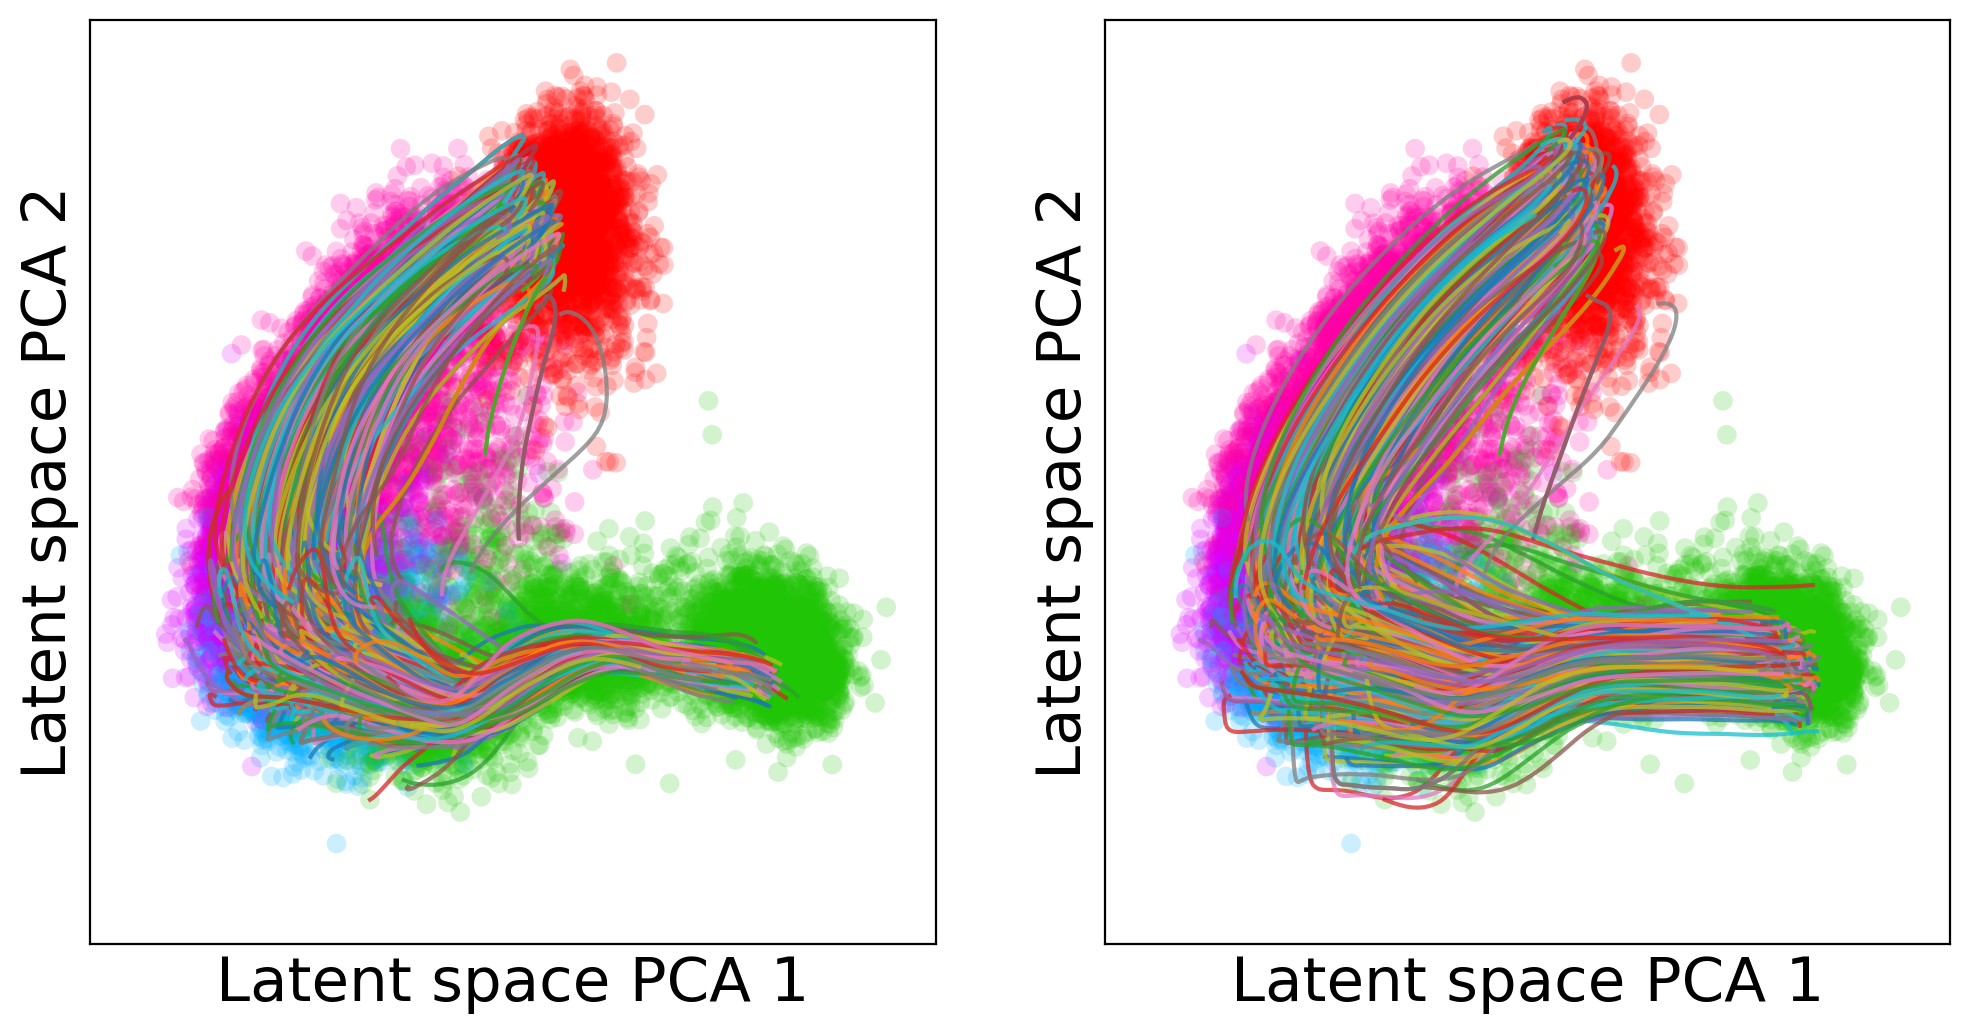

In [18]:
# plot comparison

pca = PCA()
z_pca = pca.fit_transform(z.detach().cpu().numpy())
copy = sde_model.adata.copy()
copy.obsm['X_Z_PCA'] = z_pca
copy.uns["velocity_params"] = {'embeddings':'Z_PCA'}

fig = plt.figure(figsize=(12,6), dpi=200)
ax1, ax2 = fig.subplots(1, 2)
title=''

for trajectories, ax, tit in zip(
    [sde_trajectories, det_trajectories],
    [ax1,ax2],
    ['Stochastic Training', 'Deterministic Training']
):
    t_pca=[]
    for i in range(n_trajectories):
        ti = trajectories[:,i,:].squeeze().detach().cpu().numpy()
        t_pca.append(pca.transform(ti))
    scv.pl.scatter(copy, basis='Z_PCA', frameon=True, color='cell_annotation', legend_loc=False,
                   title=title, palette=colpal.celltype, fontsize=22, legend_fontoutline=5, legend_fontsize=17,
                  ax=ax, size=200, alpha=0.2, show=False, components=f"{components[0]+1},{components[1]+1}")
    for t in t_pca:
        if one_color:
            ax.plot(t[:,components[0]],t[:,components[1]], color='blue', alpha=alpha)
        else:
            ax.plot(t[:,components[0]],t[:,components[1]], alpha=.75)
    ax.set_ylim((-8,10))
    ax.set_xlim((-8,12))
    ax.patch.set_facecolor('red')
    ax.patch.set_alpha(0.0)
    ax.set_xlabel("Latent space PCA 1")
    ax.set_ylabel("Latent space PCA 2")
plt.show()

In [19]:
X = torch.tensor(model.adata.obsm['X_z'], device=model.device)
Y_sde = sde_trajectories.reshape(-1,50)
Y_det = det_trajectories.reshape(-1,50)

X_mu, X_std =  X.mean(0), X.std(0)
Y_sde_mu, Y_sde_std =  Y_sde.mean(0), Y_sde.std(0)
Y_det_mu, Y_det_std =  Y_det.mean(0), Y_det.std(0)

# Neural

In [28]:
# load data and VAE

neural = sc.read_h5ad('../data/neural_data_0606.h5ad')

state_path = '../models/neural_vf_0606_model.pt'

vt.md.Velvet.setup_anndata(neural, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    neural,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

trained_state = torch.load(state_path)['model_state_dict']

model.module.load_state_dict(trained_state)

model.module = model.module.to('cuda')

X = torch.tensor(model.adata.obsm['X_z'], device=model.device)

INFO     Generating sequential column names                                                  


In [29]:
# define stochastic model

mp1 = vt.sb.MarkovProcess(
    model,
    n_neighbors=10,
    use_space='latent_space',
    use_spline=True,
    use_similarity=False
)

sde1 = vt.sb.SDE(
    model.module.n_latent,
    prior_vectorfield=model.module.vf,
    noise_scalar=0.2,
    device=model.device
)

model.adata.obs['index'] = np.arange(model.adata.shape[0])

vt.sm.VelvetSDE.setup_anndata(
    model, 
    x_layer='total', 
    index_key='index'
)

sde_model = vt.sm.VelvetSDE(
    model,
    sde1,
    mp1,
)

sde_model.module = sde_model.module.to('cuda')

# defome deterministic model

mp2 = vt.sb.MarkovProcess(
    model,
    n_neighbors=10,
    use_space='latent_space',
    use_spline=True,
    use_similarity=False
)

mp2.random_walk = types.MethodType(random_walk_deterministic, mp2)

sde2 = vt.sb.SDE(
    model.module.n_latent,
    prior_vectorfield=model.module.vf,
    noise_scalar=0.0,
    device=model.device
)

model.adata.obs['index'] = np.arange(model.adata.shape[0])

vt.sm.VelvetSDE.setup_anndata(
    model, 
    x_layer='total', 
    index_key='index'
)

det_model = vt.sm.VelvetSDE(
    model,
    sde2,
    mp2,
)

det_model.module = det_model.module.to('cuda')

det_model.module.loss = types.MethodType(loss_edited, det_model.module)

KNN indices for Velvet stored in .obsm['knn_index'].
KNN indices for Velvet stored in .obsm['knn_index'].


In [30]:
# train models

sde_model.train(
    max_epochs = 250,
    n_trajectories = 200,
    n_simulations = 50,
    n_steps = 30,
    n_markov_steps=15,
    t_max=25,
    dt = 1.0,
    lr = 0.001,
)

det_model.train(
    max_epochs = 250,
    n_trajectories = 200*50,
    n_simulations = 1,
    n_steps = 30,
    n_markov_steps=15,
    t_max=25,
    dt = 1.0,
    lr = 0.001,
)

Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 250/250: 100%|██████████| 250/250 [01:36<00:00,  2.59it/s, loss=147, v_num=1]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [01:36<00:00,  2.60it/s, loss=147, v_num=1]


Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 250/250: 100%|██████████| 250/250 [01:13<00:00,  3.37it/s, loss=0.36, v_num=1] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s, loss=0.36, v_num=1]


In [32]:
n_trajectories = 1000
n_steps = 200
t_max = 60
dt = 1.0
beginning_pct = 20
components=[0,1]
one_color=False
alpha=0.2

z = torch.tensor(sde_model.adata.obsm['X_z'])
z_data = sde_model.adata[[ca in ['Early_Neural','Neural'] for ca in sde_model.adata.obs.cell_annotation]]
z_data = z_data[np.random.choice(z_data.shape[0], size=n_trajectories)]
z_sub = z_data.obsm['X_z']

initial_cells = torch.tensor(z_sub, device=sde_model.device)
timespan = torch.linspace(0, t_max, n_steps, device=sde_model.device)

# stochastic model trajectories
sde_model.module.sde.noise_scalar=0.0
sde_trajectories = torchsde.sdeint_adjoint(
    sde_model.module.sde,
    initial_cells,
    timespan,
    method="midpoint",
    dt=dt
)

# deterministic model trajectories
det_trajectories = torchsde.sdeint_adjoint(
    det_model.module.sde,
    initial_cells,
    timespan,
    method="midpoint",
    dt=dt
)

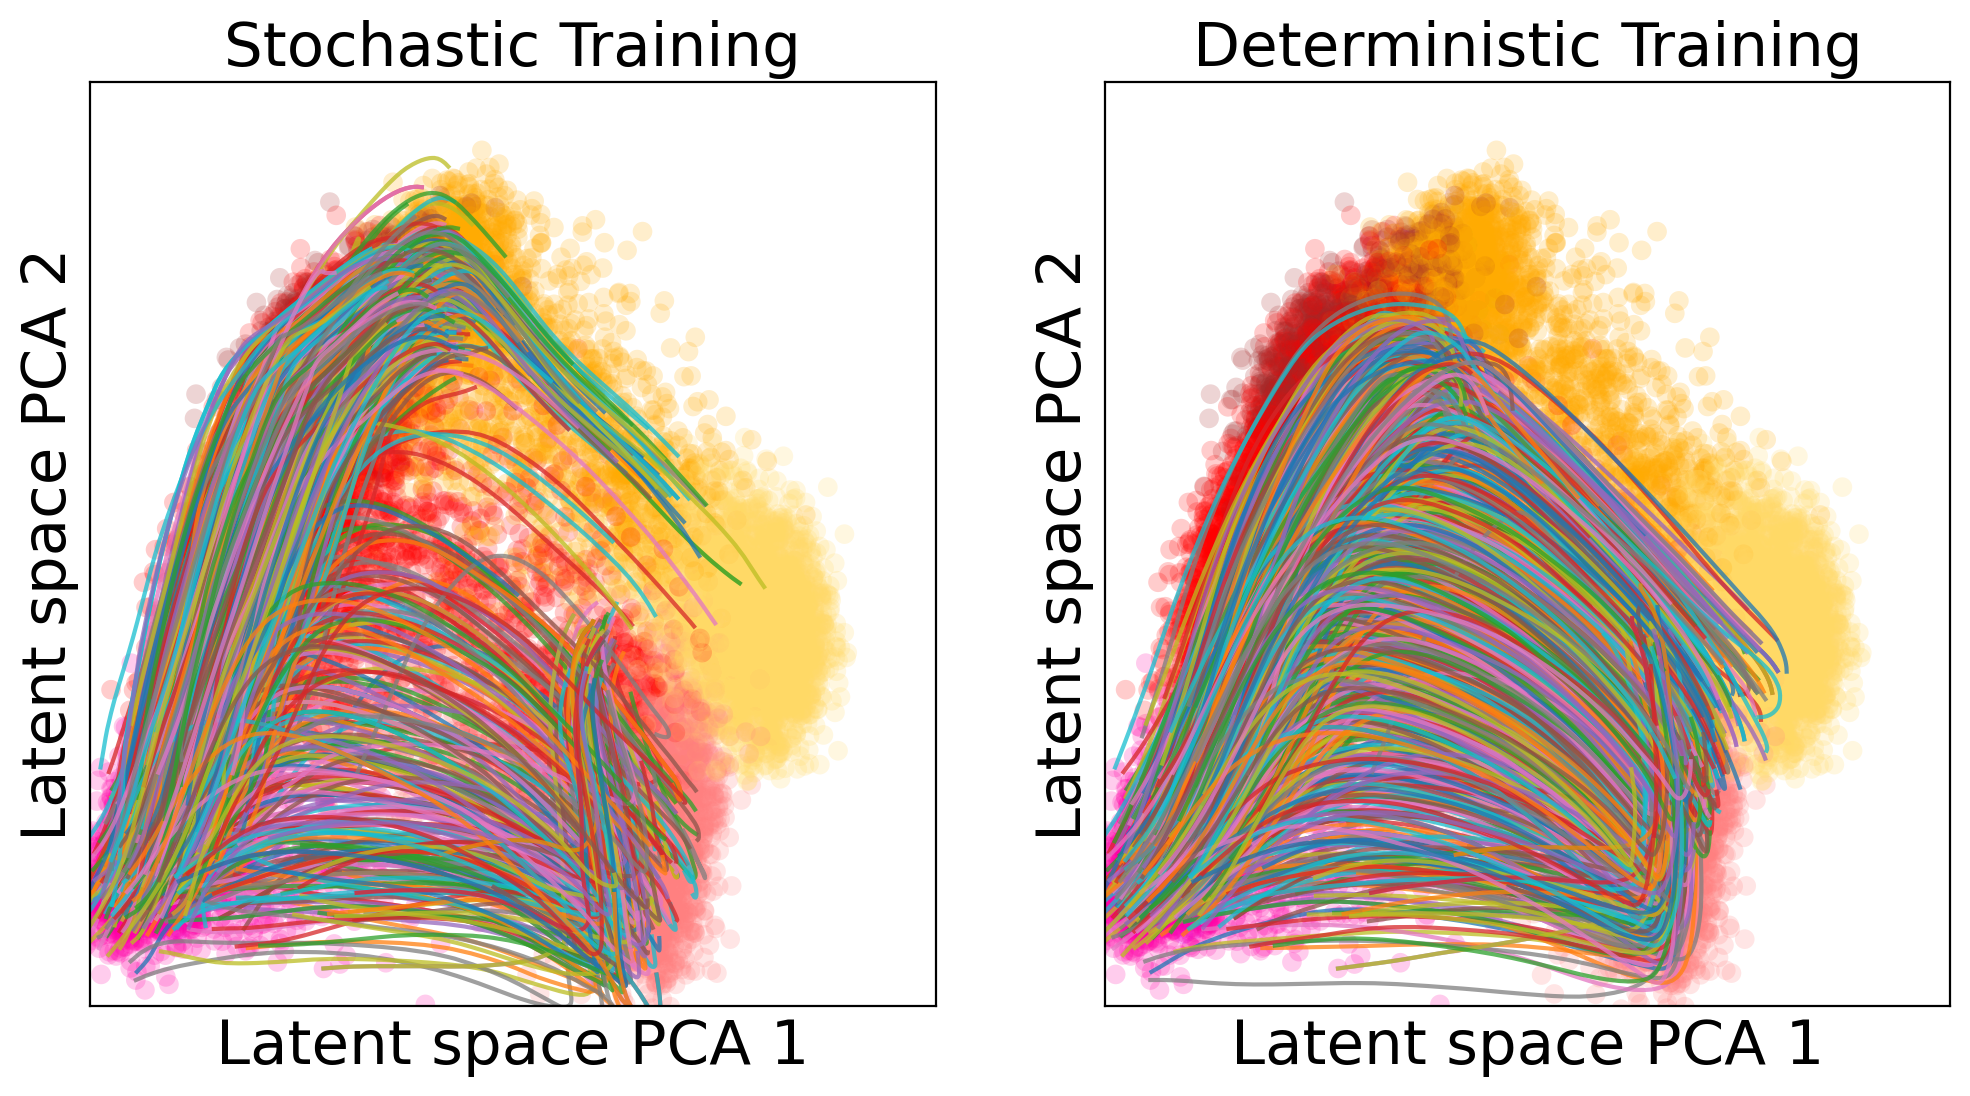

In [34]:
# plot comparison

pca = PCA()
z_pca = pca.fit_transform(z.detach().cpu().numpy())
copy = sde_model.adata.copy()
copy.obsm['X_Z_PCA'] = z_pca
copy.uns["velocity_params"] = {'embeddings':'Z_PCA'}

fig = plt.figure(figsize=(12,6), dpi=200)
ax1, ax2 = fig.subplots(1, 2)
title=''

for trajectories, ax, tit in zip(
    [sde_trajectories, det_trajectories],
    [ax1,ax2],
    ['Stochastic Training', 'Deterministic Training']
):
    t_pca=[]
    for i in range(n_trajectories):
        ti = trajectories[:,i,:].squeeze().detach().cpu().numpy()
        t_pca.append(pca.transform(ti))
    scv.pl.scatter(copy, basis='Z_PCA', frameon=True, color='cell_annotation', legend_loc=False,
                   title=tit, palette=colpal.celltype, fontsize=22, legend_fontoutline=5, legend_fontsize=17,
                  ax=ax, size=200, alpha=0.2, show=False, components=f"{components[0]+1},{components[1]+1}")
    for t in t_pca:
        if one_color:
            ax.plot(t[:,components[0]],t[:,components[1]], color='blue', alpha=alpha)
        else:
            ax.plot(t[:,components[0]],t[:,components[1]], alpha=.75)
    ax.set_ylim((-8,10))
    ax.set_xlim((-8,12))
    ax.patch.set_facecolor('red')
    ax.patch.set_alpha(0.0)
    ax.set_xlabel("Latent space PCA 1")
    ax.set_ylabel("Latent space PCA 2")
plt.show()